In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

Loading the data about universities:

In [3]:
universities = pd.read_csv('data/Universities.csv', index_col=0)
universities.head()

,name,domain,mail,authorindex,file,country
0,"University of California, Berkeley",berkeley.edu,dor@berkeley.edu,0,import2016full/61,United States
1,Utrecht University,uu.nl,s.shayan@uu.nl,1,import2016full/61,Netherlands
2,Utrecht University,uu.nl,A.Bakker4@uu.nl,2,import2016full/61,Netherlands
3,Utrecht University,uu.nl,M.F.vanderSchaaf@uu.nl,3,import2016full/61,Netherlands
4,"University of California, Los Angeles",ucla.edu,deliema@g.ucla.edu,0,import2016full/59,United States


## Base analysis of Universities present in dataset

What universities has the most contributors, adn what percentage do they make up:

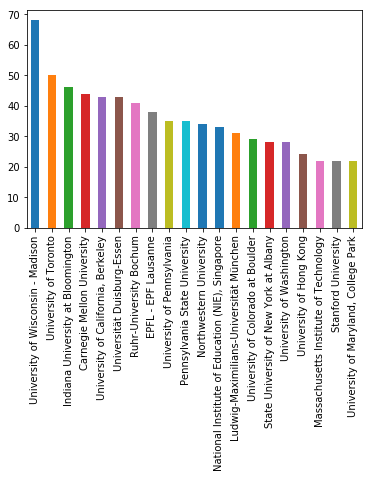

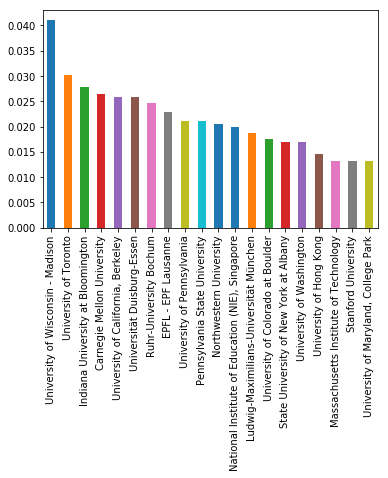

In [6]:
universities[universities.name != 'gmail'].name.value_counts().head(20).plot(kind='bar')
plt.show()
(universities[universities.name != 'gmail'].name.value_counts().head(20)/universities.shape[0]).plot(kind='bar')
plt.show()

What are the countries where the most contributors are?

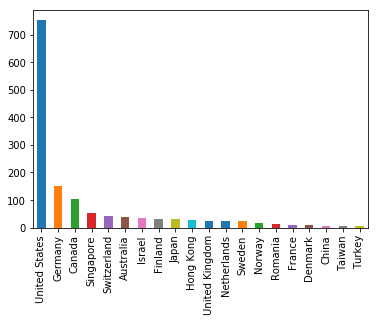

In [6]:
universities.country.value_counts().head(20).plot(kind = 'bar')

## Looking at who is where, if there are any movements:

We use the meta data from the papers submitted:

In [9]:
metadata = pd.read_csv('data/Parsed_metadata.csv', index_col=0)
print(metadata.columns)
metadata.head(2)

Index(['file', 'subject', 'iso', 'uri', 'type', 'publisher', 'title', 'issued',
       'accessioned', 'citation', 'available', 'abstract', 'value',
       'author_name_length', 'author_order', 'shortend_names'],
      dtype='object')


,file,subject,iso,uri,type,publisher,title,issued,accessioned,citation,available,abstract,value,author_name_length,author_order,shortend_names
0,import2016full/61,NaN,en,info:doi/10.22318/icls2016.61,Book chapter,Singapore: International Society of the Learni...,Exposing Piaget’s Scheme: Empirical Evidence f...,2016-07,2017-03-21 12:05:42+00:00,"Abrahamson, D., Shayan, S., Bakker, A., & van ...",2017-03-21 12:05:42+00:00,The combination of two methodological resource...,"Shayan, Shakila",15,1,Shayan S.
1,import2016full/95,NaN,en,info:doi/10.22318/icls2016.95,Book chapter,Singapore: International Society of the Learni...,Secondary Teachers’ Emergent Understanding of ...,2016-07,2017-03-21 12:05:42+00:00,"Sandoval, W. A., Kawasaki, J., Cournoyer, N., ...",2017-03-21 12:05:42+00:00,Abstract: The Next Generation Science Standard...,"Kawasaki, Jarod",15,1,Kawasaki J.


We use the author index to match up author names with indices:

In [11]:
universities['merge_index'] = universities.apply(lambda x: x['file']+str(x['authorindex']), axis=1)
metadata['merge_index'] = metadata.apply(lambda x: x['file']+str(x['author_order']), axis=1)
associations = pd.merge(universities, metadata, on='merge_index')

associations.sample(10)[['mail', 'shortend_names']]

,mail,shortend_names
1067,brendita@uic.edu,Silva B. L.
1297,parkmi@gse.upenn.edu,Park M.
1043,lucila.carvalho@sydney.edu.au,Carvalho L.
1336,noora@gse.upenn.edu,Noushad N. F.
771,kelba@live.unc.edu,Barber-Lester K. J.
825,heis@hallym.ac.kr,Jeong H.
1134,nicolas.bresser@gmx.de,Bresser N.
1404,susanne.lajoie@mcgill.ca,Lajoie S. P.
1248,moher@uic.edu,Moher T.
850,claudia.mazziotti@rub.de,Mazziotti C.


In [13]:
name_country = associations[['shortend_names','country', 'name']]
name_country.shape

(1650, 3)

## Looking at people moving around

We now look at people who moved from one country to an other within the period of the papers in the parsed papers:

In [14]:
#Add year to see
df = pd.merge(name_country, name_country, on='shortend_names').dropna()
df[df.country_x != df.country_y].drop_duplicates()[['shortend_names', 'country_x', 'country_y']]

,shortend_names,country_x,country_y
933,Sun Z.,Denmark,United States
935,Sun Z.,United States,Denmark
1664,Tan E.,United States,Germany
1666,Tan E.,Germany,United States
2234,Weinberger A.,Germany,Israel
2244,Weinberger A.,Israel,Germany
2486,Wise A. F.,Canada,United States
2495,Wise A. F.,United States,Canada
2686,Prieto L. P.,Switzerland,Estonia
2702,Prieto L. P.,Estonia,Switzerland


In [15]:
df[df.country_x != df.country_y].drop_duplicates().shape[0]/2

11.0

In [16]:
df = pd.merge(name_country, name_country, on='shortend_names').dropna()
df[(df.name_x != df.name_y) & (df.country_x == df.country_y)].drop_duplicates()[['shortend_names', 'name_x', 'name_y']]

,shortend_names,name_x,name_y
85,McKenney S.,University of Twente,Open University of the Netherlands
87,McKenney S.,Open University of the Netherlands,University of Twente
102,Schneider B.,Stanford University,Harvard University
158,Schneider B.,Harvard University,Stanford University
177,Sharma K.,EPFL - EPF Lausanne,Université de Lausanne
186,Sharma K.,Université de Lausanne,EPFL - EPF Lausanne
717,Loibl K.,Ruhr-University Bochum,Pädagogische Hochschule Freiburg
723,Loibl K.,Pädagogische Hochschule Freiburg,Ruhr-University Bochum
824,Csanadi A.,Ludwig-Maximilians-Universität München,Technische Universität Darmstadt
826,Csanadi A.,Technische Universität Darmstadt,Ludwig-Maximilians-Universität München


In [ ]:
drop = df[(df.name_x != df.name_y) & (df.country_x == df.country_y)].drop_duplicates()[['shortend_names', 'name_x', 'name_y']]
drop.apply(lambda x: )

Number of people that changed organisation:

In [17]:
df[(df.name_x != df.name_y) & (df.country_x == df.country_y)].drop_duplicates().shape[0]/2

18.0

# Looking at where people collaborate:

In [18]:
pub_collab = associations[['file_x','country']].drop_duplicates()
collabs = pd.merge(pub_collab, pub_collab, on='file_x').drop_duplicates()

collabs.head()

,file_x,country_x,country_y
0,import2016full/61,United States,United States
1,import2016full/61,United States,Netherlands
2,import2016full/61,Netherlands,United States
3,import2016full/61,Netherlands,Netherlands
4,import2016full/59,United States,United States


Building collaboration graph:

In [19]:
nodes = pd.DataFrame(collabs.country_x.dropna().unique())
nodes.columns = ['country']
nodes.reset_index(inplace=True)
nodes

,index,country
0,0,United States
1,1,Netherlands
2,2,United Kingdom
3,3,Switzerland
4,4,Finland
5,5,Singapore
6,6,Germany
7,7,Israel
8,8,India
9,9,Norway


In [21]:
edges = pd.merge(nodes, collabs[collabs.country_x != collabs.country_y], left_on='country', right_on='country_x')
edges = pd.merge(nodes, edges, left_on='country', right_on='country_y')
edges[['index_x', 'index_y']].head()

,index_x,index_y
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [25]:
n_nodes = len(nodes)
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

for idx, row in edges.iterrows():
    i, j = int(row.index_x), int(row.index_y)
    adjacency[i, j] += 1

In [26]:
adjacency

array([[0, 9, 7, ..., 0, 0, 1],
       [9, 0, 2, ..., 0, 1, 1],
       [7, 2, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]])

In [27]:
graph = nx.from_numpy_array(adjacency)

mapping = nodes.country.to_dict()

H=nx.relabel_nodes(graph,mapping)
print(sorted(H.nodes()))

nx.write_gexf(H, 'data/country_graph.gexf')

['Australia', 'Belgium', 'Brazil', 'Canada', 'Chile', 'China', 'Colombia', 'Cyprus', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Hong Kong', 'India', 'Iran', 'Ireland', 'Israel', 'Italy', 'Japan', 'Korea, Republic of', 'Netherlands', 'Norway', 'Qatar', 'Romania', 'Singapore', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Taiwan', 'Turkey', 'United Kingdom', 'United States']


Most intercountry collaborations overall:

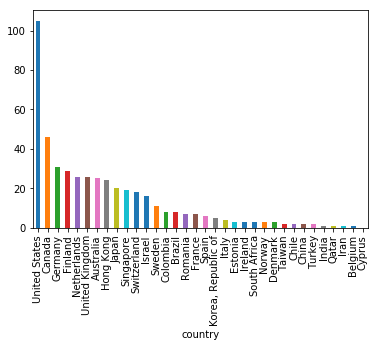

In [40]:
nodes['degrees'] = pd.Series(adjacency.sum(axis=1))
nodes.set_index('country').degrees.sort_values(ascending=False).plot(kind='bar')

What country has most collaborations with different countries?

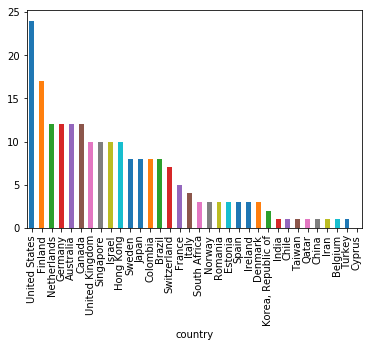

In [39]:
nodes['degrees'] = pd.Series(np.where(adjacency > 0, 1, 0).sum(axis=1))
nodes.set_index('country').degrees.sort_values(ascending=False).plot(kind='bar')

# Do the same for university:

In [60]:
pub_collab = associations[['file_x','name']].drop_duplicates()
pub_collab = pub_collab[pub_collab.name != 'gmail']
collabs = pd.merge(pub_collab, pub_collab, on='file_x').drop_duplicates()

nodes = pd.DataFrame(collabs.name_x.dropna().unique())
nodes.columns = ['name']
nodes.reset_index(inplace=True)

edges = pd.merge(nodes, collabs[collabs.name_x != collabs.name_y], left_on='name', right_on='name_x')
edges = pd.merge(nodes, edges, left_on='name', right_on='name_y')

n_nodes = len(nodes)
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

for idx, row in edges.iterrows():
    i, j = int(row.index_x), int(row.index_y)
    adjacency[i, j] += 1
    
graph = nx.from_numpy_array(adjacency)
mapping = nodes.name.to_dict()

H=nx.relabel_nodes(graph,mapping)

nx.write_gexf(H, 'data/institution_graph.gexf')

Number of cross institution collaboration:

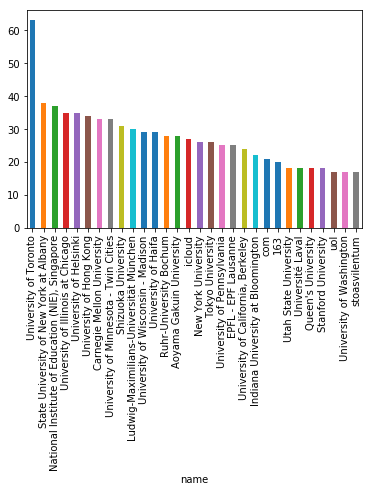

In [62]:
nodes['degrees'] = pd.Series(adjacency.sum(axis=1))
nodes.set_index('name').degrees.sort_values(ascending=False).head(30).plot(kind='bar')

Number of distinct different institution collbaorations:

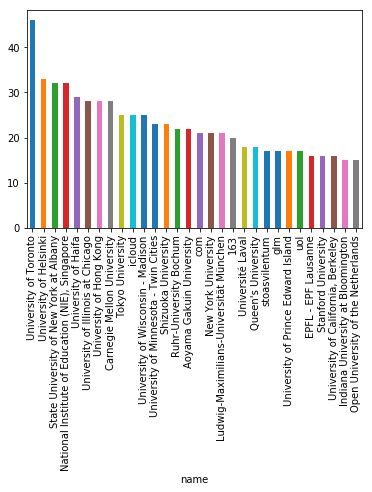

In [59]:
nodes['degrees'] = pd.Series(np.where(adjacency > 0, 1, 0).sum(axis=1))
nodes.set_index('name').degrees.sort_values(ascending=False).head(30).plot(kind='bar')